# Predicting Football Game Results

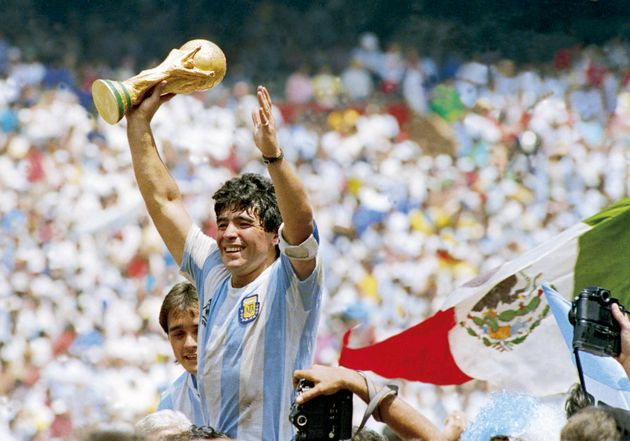



> Football is the most popular sport in the world
> There is a bench of data/actors behind a simple game :


*   Players - Coach - Staff - Marketing Team - Supporters 
*   Data : Win - Lose - Draw - Shot - On target - Passes
*   Salary - Transfer - Sponsoring - TV Industry
*   Wheather conditions - Feeling bewteen Players...






# Import Dependencies

In [4]:
"""
BOX GOAL : IMPORT ALL DEPENDENCIES.
"""


import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from IPython.display import display
from matplotlib import *
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
import plotly.io as pio

In [ ]:
"""
BOX GOAL : DISPLAY PLOTLY GRAPHS ON GITHUB (only for the Data Viz part)

If we present on Google Colab, we have to remove the ' renderer = "svg" ' on fig.show()
Because it makes the figs statics, and no dynamic no more.
But in Google Colab, I prefer have statics figure than nothing.
"""

!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [5]:
"""
BOX GOAL : IMPORT THE DATA AND DISPLAY A COUPLE OF ROWS
"""

# Read data and drop redundant column.
data = pd.read_csv('PL.csv')

# Preview data.
data.head()


# FTR = Full time result
# FTHG = Full time home goals
# FTAG = Full time away goals
# HTR = Half time result
# HTHG = Half time home goals
# HTAG = Half time away goals
# ETR = Extra time Result
# ETHG = Extra time home goals
# ETAG = Extra time away goals
# PENR = Penalty shootout Result
# PENHG = Penalty shootout home goals
# PENAG = Penalty shootout away goals
# H_ST = Home team shots total
# H_SOG = Home team shots on goal
# H_SFG = Home team shots off goal
# H_PT = Home team possession time
# H_COR = Home team corners
# H_FL = Home team fouls
# H_TC = Home team yellow cards
# H_RC = Home team red cards
# A_ST = Away team shots total
# A_SOG = Away team shots on goal
# A_SFG = Away team shots off goal
# A_PT = Away team possession time
# A_COR = Away team corners
# A_FL = Away team fouls
# A_TC = Away team yellow cards
# A_RC = Away team red cards

,Date,Country,League,Type,Season,Home_Team,Away_team,FTR,FTHG,FTAG,HTR,HTHG,HTAG,ETR,ETHG,ETAG,PENR,PENHG,PENAG,H_ST,H_SOG,H_SFG,H_PT,H_COR,H_FL,H_YC,H_RC,A_ST,A_SOG,A_SFG,A_PT,A_COR,A_FL,A_YC,A_RC
0,2017-08-11,England,Premier League,LEAGUE,2017/2018,Arsenal,Leicester City,2,4,3,D,2,2,NaN,NaN,NaN,NaN,NaN,NaN,27,10,9,64,9,9,0,0,6,3,3,36,4,12,1,0
1,2017-08-12,England,Premier League,LEAGUE,2017/2018,Chelsea,Burnley,1,2,3,A,0,3,NaN,NaN,NaN,NaN,NaN,NaN,19,6,6,59,8,16,4,2,10,5,4,41,5,11,3,0
2,2017-08-12,England,Premier League,LEAGUE,2017/2018,Watford,Liverpool,0,3,3,H,2,1,NaN,NaN,NaN,NaN,NaN,NaN,9,4,4,49,3,14,0,0,14,5,8,51,3,8,3,0
3,2017-08-12,England,Premier League,LEAGUE,2017/2018,Brighton & Hove Albion,Manchester City,1,0,2,D,0,0,NaN,NaN,NaN,NaN,NaN,NaN,6,2,2,27,3,6,0,0,14,4,5,73,10,9,2,0
4,2017-08-12,England,Premier League,LEAGUE,2017/2018,Southampton,Swansea City,0,0,0,D,0,0,NaN,NaN,NaN,NaN,NaN,NaN,29,2,16,59,13,10,2,0,4,0,2,41,0,13,1,0


In [ ]:
data.FTR.unique()
# 2 means Home Team Win
# 1 means Away Team Win
# 0 means Draw

array([2, 1, 0])

In [ ]:
"""
BOX GOAL : DISPLAY A SUMMARY OF OUR FEATURES
"""

print('The dataframe shape is :', data.shape)
print('Very basic stuff:')
data.describe()

The dataframe shape is : (1139, 35)
Very basic stuff:


,FTR,FTHG,FTAG,HTHG,HTAG,ETR,ETHG,ETAG,PENR,PENHG,PENAG,H_ST,H_SOG,H_SFG,H_PT,H_COR,H_FL,H_YC,H_RC,A_ST,A_SOG,A_SFG,A_PT,A_COR,A_FL,A_YC,A_RC
count,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,0.0,0.0,0.0,0.0,0.0,0.0,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000
mean,1.232660,1.539947,1.202809,0.662862,0.546971,NaN,NaN,NaN,NaN,NaN,NaN,13.633889,4.647059,6.639157,50.861282,5.740123,10.239684,1.568920,0.049166,11.080773,3.919227,5.437226,49.138718,4.679543,10.533802,1.733099,0.064091
std,0.798364,1.299903,1.185794,0.848103,0.760536,NaN,NaN,NaN,NaN,NaN,NaN,5.691878,2.633453,3.611237,12.926386,3.066497,3.394864,1.264404,0.224287,4.907095,2.357087,3.240813,12.926386,2.782704,3.550718,1.281497,0.248584
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,3.000000,4.000000,42.000000,3.000000,8.000000,1.000000,0.000000,7.000000,2.000000,3.000000,39.000000,3.000000,8.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,13.000000,4.000000,6.000000,51.000000,5.000000,10.000000,1.000000,0.000000,11.000000,4.000000,5.000000,49.000000,4.000000,10.000000,2.000000,0.000000
75%,2.000000,2.000000,2.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,17.000000,6.000000,9.000000,61.000000,8.000000,12.000000,2.000000,0.000000,14.000000,5.000000,7.000000,58.000000,6.000000,13.000000,3.000000,0.000000
max,2.000000,8.000000,9.000000,5.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,36.000000,16.000000,22.000000,83.000000,18.000000,23.000000,7.000000,2.000000,30.000000,15.000000,20.000000,83.000000,16.000000,26.000000,7.000000,2.000000


# Data Processing

In [6]:
"""
BOX GOAL : SPLIT THE INTEREST VAR Y AND THE FEATURES MATRIX X AND SCALE THEM

Preparing the data. Our target Y will be FTR = Full Time Result.
That's the interesting variable. Others variables are features X.
We also have to scale the variables to avoid sizes problems.
"""


# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['H_ST','H_SOG','H_SFG','H_PT','H_COR','H_FL','H_YC','H_RC','A_ST','A_SOG','A_SFG','A_PT','A_COR','A_FL','A_YC','A_RC']]
for col in cols:
    X_all[col] = scale(X_all[col])

In [7]:
"""
BOX GOAL : DROP ALL THE USELESS VARIABLES AND SCALE THE OTHERS

We have to drop all the str varibales, for our features we only want numbers !
We also display a couple of lines to have an little idea
"""

X_all = data.drop(['HTAG','HTHG','FTAG','FTHG','HTR','Date','FTR','Country','League','Type','Season','Home_Team','Away_team','ETR','ETHG','ETAG','PENR','PENHG','PENAG'],1)

# Show the feature information by printing the first five rows
print("\nFeature values:")
display(X_all.head())


Feature values:


,H_ST,H_SOG,H_SFG,H_PT,H_COR,H_FL,H_YC,H_RC,A_ST,A_SOG,A_SFG,A_PT,A_COR,A_FL,A_YC,A_RC
0,27,10,9,64,9,9,0,0,6,3,3,36,4,12,1,0
1,19,6,6,59,8,16,4,2,10,5,4,41,5,11,3,0
2,9,4,4,49,3,14,0,0,14,5,8,51,3,8,3,0
3,6,2,2,27,3,6,0,0,14,4,5,73,10,9,2,0
4,29,2,16,59,13,10,2,0,4,0,2,41,0,13,1,0


In [8]:
"""
BOX GOAL : HAVE A X-MATRIX WITH ONLY RELEVANT FEATURES.

To maximize performance of our classifiers we have to choose to more relevant features. For that, we will use one of
technics :
  - Variance Thresold
  - SelectKBest
  - SelectFromModel
  - CoefficientMatrix
  - RPE
Thresold look a the variance of the features and remove feautures that does not vary a lot.
The others choose features using stats test or coeff estimation.
In our case we will choose the Khi-2 dependancy test which is common on classification problem. 
(There is the ANOVA test too that we could have choose)
We choose k=5 arbitraty because we want to work with 5 features.

At the end of this box code we have our X matrix feature with only 5 more relevant features
"""
from sklearn.feature_selection import SelectKBest, chi2

sel = SelectKBest(chi2, k = 5)
sel.fit(X_all, y_all)
X = sel.transform(X_all)
X = pd.DataFrame(X)
X

,0,1,2,3,4
0,27,10,6,3,36
1,19,6,10,5,41
2,9,4,14,5,51
3,6,2,14,4,73
4,29,2,4,0,41
...,...,...,...,...,...
1134,13,1,12,3,46
1135,3,2,14,6,75
1136,13,5,19,6,49
1137,31,10,5,4,27


# Data Visualisation

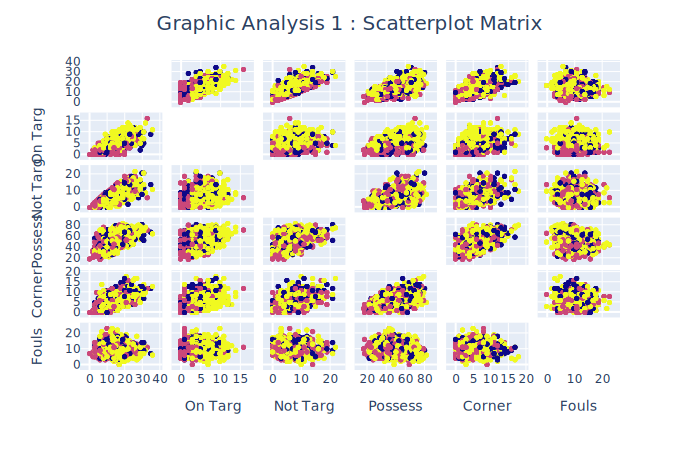

In [19]:


import plotly.express as px
df = pd.read_csv('PL.csv')


scattermatrix = px.scatter_matrix(df,
    dimensions=['H_ST', 'H_SOG', 'H_SFG', 'H_PT', 'H_COR', 'H_FL'],
    color = "FTR",
    labels={
        "H_SOG": "On Targ",
        "H_SFG": "Not Targ",
        "H_PT": "Possess",
        "H_COR": "Corner",
        "H_FL": "Fouls"
        }
    )

scattermatrix.update_traces(marker=dict(size=5), diagonal_visible=False)
scattermatrix.update_layout(title = "Graphic Analysis 1 : Scatterplot Matrix",
                      title_x = 0.5, title_font_size = 20, coloraxis_showscale=False,
                      xaxis_title=" ",
                      yaxis_title=" ")


scattermatrix.show(renderer="svg")

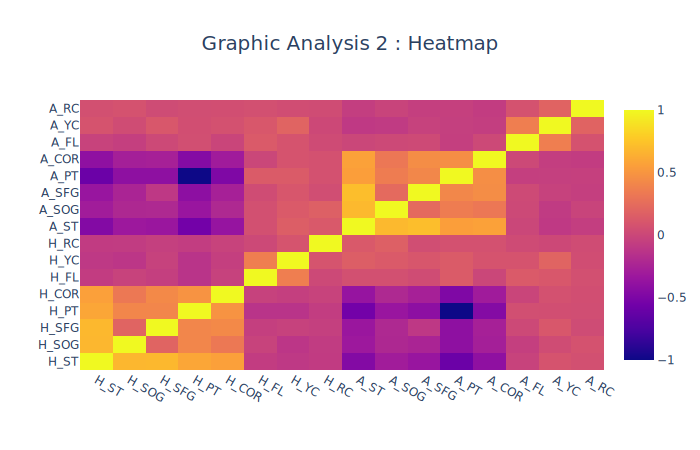

In [20]:
import plotly.graph_objs as go
correlations = X_all.corr()
np.array(correlations)

x_var = ['H_ST', 'H_SOG', 'H_SFG', 'H_PT', 'H_COR', 'H_FL', 'H_YC', 'H_RC','A_ST', 'A_SOG', 'A_SFG', 'A_PT', 'A_COR', 'A_FL', 'A_YC', 'A_RC']
y_var = ['H_ST', 'H_SOG', 'H_SFG', 'H_PT', 'H_COR', 'H_FL', 'H_YC', 'H_RC','A_ST', 'A_SOG', 'A_SFG', 'A_PT', 'A_COR', 'A_FL', 'A_YC', 'A_RC']

trace = go.Heatmap(
   x = x_var,
   y = y_var,
   z = correlations,
   type = 'heatmap',
   colorscale = 'Plasma'
)
data = [trace]
heatmap = go.Figure(data = data)
heatmap.update_layout(title = "Graphic Analysis 2 : Heatmap",
                      title_x = 0.5, title_font_size = 20, coloraxis_showscale=False,
                      xaxis_title=" ",
                      yaxis_title=" ")
heatmap.show(renderer="svg")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



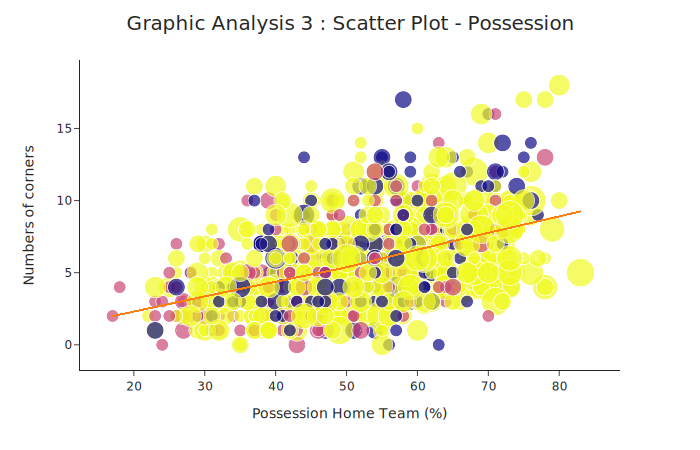

In [21]:
import plotly.express as px
df = pd.read_csv('PL.csv')
scat1 = px.scatter(df, x=df["H_PT"], y="H_COR", color="FTR",color_continuous_scale=px.colors.sequential.Plasma, trendline="lowess", template="simple_white", size="FTHG",
                 labels={
                     "H_PT": "Possession Home Team (%)",
                     "H_COR": "Numbers of corners "
                 },
                title="")
scat1.update_layout(title = "Graphic Analysis 3 : Scatter Plot - Possession",
                      title_x = 0.5, title_font_size = 20, coloraxis_showscale=False)
scat1.show(renderer="svg")


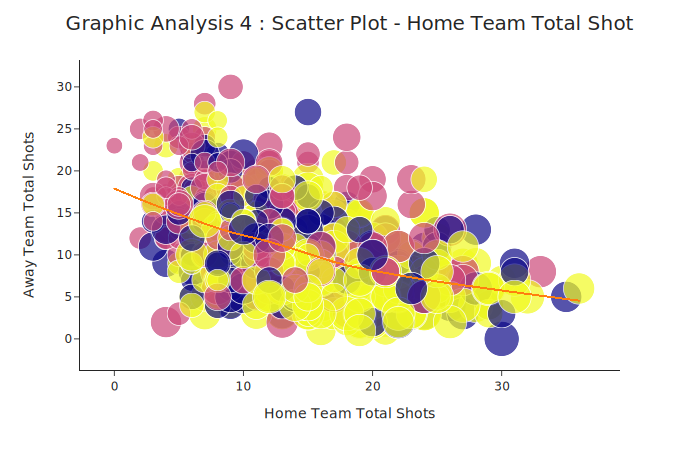

In [22]:
import plotly.express as px
df = pd.read_csv('PL.csv')
scat2 = px.scatter(df, x="H_ST", y="A_ST", color=y_all, color_continuous_scale=px.colors.sequential.Plasma, trendline="lowess", template="simple_white", size="H_PT",
                 labels={
                     "H_ST": "Home Team Total Shots",
                     "A_ST": "Away Team Total Shots"
                 },
                title="")

scat2.update_layout(title = "Graphic Analysis 4 : Scatter Plot - Home Team Total Shot",
                      title_x = 0.5, title_font_size = 20, coloraxis_showscale=False)
scat2.show(renderer="svg")




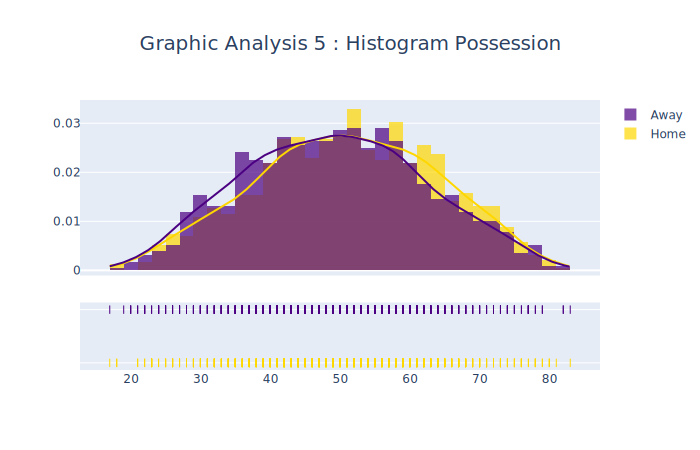

In [23]:
import plotly.figure_factory as ff
import numpy as np
import pandas as pd


df = pd.read_csv('PL.csv')
df_hist = pd.DataFrame({'Home':  df['H_PT'], 'Away': df['A_PT']})
colors = ['rgb(255,215,0)', 'rgb(75,0,130)']
hist = ff.create_distplot([df_hist[c] for c in df_hist.columns], df_hist.columns, bin_size=2, colors=colors )
hist.update_layout(title = "Graphic Analysis 5 : Histogram Possession",
                      title_x = 0.5, title_font_size = 20, coloraxis_showscale=False)
hist.show(renderer="svg")


In [ ]:
pip install plotly==4.7.1

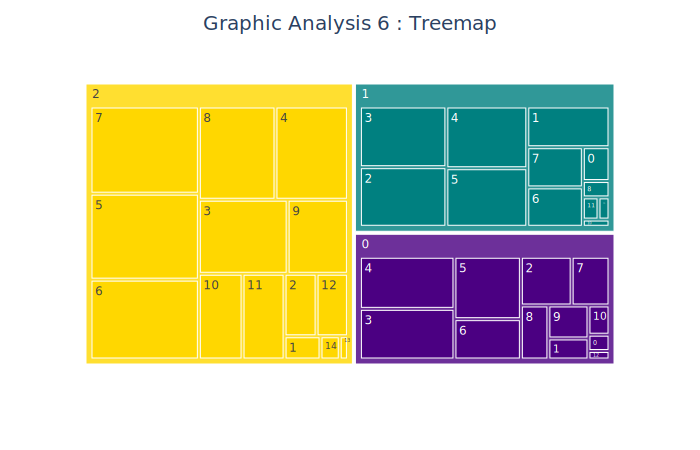

In [1]:
"""
ATTENTION : La version 4.7.1 de plotly est nécessaire pour le Treemap.
De plus quand j'a rentré l'argument data j'ai eu une erreur ;
DataFrame constructor not properly called.
Car data est un mot clé.... 
"""


from plotly import *
import plotly.express as px
import plotly.graph_objects as pg
import pandas as pd

df2 = pd.DataFrame(pd.read_csv('PL.csv'))

treemap = px.treemap(df2, path=["FTR", "H_SOG"],
                 values="H_ST",
                 title=""
                 )
treemap.update_layout(treemapcolorway =  ["Gold ", "Teal ", "Indigo"])
treemap.update_layout(title = "Graphic Analysis 6 : Treemap ",
                      title_x = 0.5, title_font_size = 20, coloraxis_showscale=False)
treemap.show(renderer="svg")


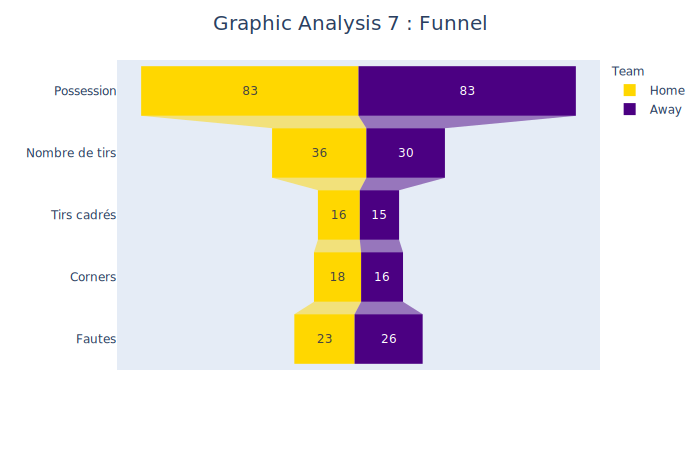

In [2]:
import plotly.express as px
import pandas as pd
df = pd.read_csv('PL.csv')
color_discrete_map = {'Home': 'rgb(255,215,0)', 'Away': 'rgb(75,0,130)'}

stages = ["Possession", "Nombre de tirs", "Tirs cadrés", "Corners", "Fautes"]
df_home = pd.DataFrame(dict(number=[df['H_PT'].max(), df['H_ST'].max(), df['H_SOG'].max(), df['H_COR'].max(), df['H_FL'].max()], stage=stages))
df_home['Team'] = 'Home'
df_away = pd.DataFrame(dict(number=[df['A_PT'].max(), df['A_ST'].max(), df['A_SOG'].max(), df['A_COR'].max(), df['A_FL'].max()], stage=stages))
df_away['Team'] = 'Away'
df = pd.concat([df_home, df_away], axis=0)
funnel = px.funnel(df, x='number', y='stage', color='Team',color_discrete_map=color_discrete_map)
funnel.update_layout(title = "Graphic Analysis 7 : Funnel",
                      title_x = 0.5, title_font_size = 20, coloraxis_showscale=False,
                      xaxis_title=" ",
                      yaxis_title=" ")
funnel.show(renderer="svg")

# Training and Evaluating Models








In [ ]:
"""
BOX GOAL : SPLIT OUR X MATRIX AND Y VECTOR INTO ONE PART FOR THE TRAINING AND ONE FOR THE TESTING

Sklearn is the most efficient way to split our data in train and test set
using the fonction train_test_split()

The result is we have 4 variables, 2 for training and 2 for testing.
"""

from sklearn.model_selection import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y_all, 
                                                    test_size = 0.20,
                                                    random_state = 3,
                                                    stratify = y_all)
print("Data for the train : ", X_train.shape)
print("Data for the test : ", X_test.shape)

Data for the train :  (911, 5)
Data for the test :  (228, 5)


# Tuning Hyperparameters



Logistic Regression

In [ ]:
"""
BOX GOAL : WE TRY TO TUN HYPERPARAMETERS

In logistic regression case, we try to tun the penalty 
solver and max_iter parameters. Even if we don't know really whats behind thoses params
we can thanks to the gridsearchcv find the opitmal combinaison of parameters.
In this case GridSearch will implemente a combinaison like : penalty * solver * max_iter * CV
Note : There is others parameters we could have tuned but it would take so long time.

"""
from sklearn.model_selection import GridSearchCV

logModel = LogisticRegression()
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

LogGrid = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [ ]:
BestLog = LogGrid.fit(X_train,y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    6.7s finished


In [ ]:
print("Les meilleurs paramètres sont : ", BestLog.best_params_)
print("Le meilleur score est : ", BestLog.best_score_)

Les meilleurs paramètres sont :  {'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}
Le meilleur score est :  0.6180048925945226


Random Forest

In [ ]:
"""
BOX GOAL : WE TRY TO TUN HYPERPARAMETERS

In random forest case, we try to tun the n_estimators parameters
which represents the numbers of tree of our random forrest used to 
construct our predictions model and the max_features parameters which 
is the number of features. GridSearchCV will allow us to search 
for the best hyperparameter in a optimal way. The grid will test all the
possible combination of our pair of parameters

"""
from sklearn.model_selection import GridSearchCV


max_features_range = np.arange(1,6,1)
n_estimators_range = np.arange(10,210,10)
param_grid = dict(max_features=max_features_range, n_estimators=n_estimators_range)
rf = RandomForestClassifier()
RandGrid = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 5)

In [ ]:
RandGrid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print("Les meilleurs paramètres sont : ", RandGrid.best_params_)
print("Le meilleur score est : ", RandGrid.best_score_)

Les meilleurs paramètres sont :  {'max_features': 1, 'n_estimators': 60}
Le meilleur score est :  0.5949558638083229


Support Vector Machine

In [ ]:
from sklearn.model_selection import GridSearchCV

SuperVector = SVC()
param_grid = {'C':[0.1,1], 'kernel':['rbf', 'poly', 'sigmoid','linear'], 'degree':[1,2,3]}
SVMGrid=GridSearchCV(estimator=SuperVector, param_grid=param_grid)

In [ ]:
SVMGrid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1], 'degree': [1, 2, 3],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print("Les meilleurs paramètres sont : ", SVMGrid.best_params_)
print("Le meilleur score est : ", SVMGrid.best_score_)

Les meilleurs paramètres sont :  {'C': 1, 'degree': 1, 'kernel': 'linear'}
Le meilleur score est :  0.610304449648712


In [ ]:
LogPred = LogGrid.predict(X_test)
RandPred = RandGrid.predict(X_test)
SVMPred = SVMGrid.predict(X_test)
res = pd.DataFrame([LogPred, RandPred, SVMPred, y_test]).transpose().head(10) #this is my prediction (0:A_pred, etc.)
res.columns = ['LogPred', 'RandPred', 'SVMPred', 'Y']
print(" Tableau comparatif des resultats : ", res)

,LogPred,RandPred,SVMPred,Y
0,0,0,0,1
1,2,2,2,2
2,2,2,2,1
3,1,1,1,2
4,2,2,2,1
5,1,2,1,2
6,2,0,2,2
7,2,2,2,2
8,2,2,2,2
9,0,0,2,2


# Artifical Neural Network


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from IPython.display import HTML

# Youtube
HTML('<iframe width="800" height="400" src="https://www.youtube.com/embed/rEDzUT3ymw4?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

In [ ]:
y_train

1012    0
325     2
203     2
1008    2
64      0
       ..
992     0
157     1
349     2
769     2
1052    1
Name: FTR, Length: 911, dtype: int64

In [ ]:
"""
BOX GOAL : CATEGORIZE RESPONSE VARIABLE

Since our target variable represents a 3-labels category which has been coded as numbers 0,1 and 2
we will have to encode it. We can easily achieve that using the "to_categorical" function from the Keras
package. The two lines of code below accomplishes that in both training and test datasets.
"""
Y_train = to_categorical(y_train, 3)
Y_test = to_categorical(y_test, 3)

count_classes = Y_test.shape[1]
print("Number of possibles labels for Y : ", count_classes)

Number of possibles labels for Y :  3


In [ ]:
"""
BOX GOAL : INITIALISE AND COMPILE CLASSIFICATION MODEL WITH KERAS

We will first initialise our model. The first line of code calls for the Sequential constructor.
We are using the Sequential model because our network consists of several layers.
The second line of code represents the input layer which specifies the activation function and the number
of input dimensions, which in our case is 3 predictors (Win, Draw and Lose). Then we repeat the same process in the 
third and fourth line of codes for the two hidden layers, but this time without the input_dim parameter.
The activation function  used is a rectified linear unit, or ReLU. ReLU is the most widely used activation function
because it is nonlinear and has the ability to not activate ALL the neurons at the SAME TIME.
The fifth line of code creates the output layer with 3 nodes because there are 3 output classes, 0, 1 and 2 as explained
above.
We use 'softmax' as the activation function for the output layer, so that the sum of the predicted values from
all the neurons in the output layer adds up to one.
But before we can start training the model, we will configure the learning process.
This is done in the last line of code using the model.compile() function.
In defining our compiler, we will use 'categorical cross-entropy' as our loss measure because again, we have 3 output
classes and we don't want to use 'binary cross-entropy' which fit better for 2 output classes. 
We choose 'adam' as the optimizer algorithm and 'accuracy' as the evaluation metric. The main advantage of the "adam" 
optimizer is that we don't need to specify the learning rate, as is the case with gradient descent.
Using “adam” will, thereby, save us the task of optimizing the learning rate for our model.
The evaluation metrics 'accuracy' will be inferred automatically based on the loss function used which is here
'categorical_crossentropy'.
"""


model = Sequential()
model.add(Dense(1000, activation='relu', input_dim=5))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Bianchini comment from december :Input shape represent the number of columns if you have a dataframe or the channels in input if you have an image
# Bianchini comment from december : A lot of parameters (epochs, loss, etc.) are not properly set...
# epochs was 5, and loss was 'binary_crossentropy'
# -----------> accuracy was around 28% or 29%

# Now we changed epochs = 20 and loss='categorical_crossentropy'
# -----------> accuracy is now around 60%

In [ ]:
# build the model
model.fit(X_train, Y_train, epochs=20)

Epoch 1/20
29/29 [==============================] - 1s 10ms/step - loss: 2.3270 - accuracy: 0.4085
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 1.0012 - accuracy: 0.5003
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.9566 - accuracy: 0.5456
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 0.8562 - accuracy: 0.6241
Epoch 5/20
29/29 [==============================] - 0s 9ms/step - loss: 0.8353 - accuracy: 0.6201
Epoch 6/20
29/29 [==============================] - 0s 9ms/step - loss: 0.8978 - accuracy: 0.5880
Epoch 7/20
29/29 [==============================] - 0s 9ms/step - loss: 0.8701 - accuracy: 0.6129
Epoch 8/20
29/29 [==============================] - 0s 9ms/step - loss: 0.8507 - accuracy: 0.6168
Epoch 9/20
29/29 [==============================] - 0s 9ms/step - loss: 0.8903 - accuracy: 0.5820
Epoch 10/20
29/29 [==============================] - 0s 9ms/step - loss: 0.8700 - accuracy: 0.6086
Epoch 11/20
29/29 

In [ ]:
"""
BOX GOAL : PREDICTIONS AND EVALUATION

Predict on the Test Data and Compute Evaluation Metrics;
The first line of code predicts on the train data, while the second line evaluates the model
and the third line prints the accuracy and error on the training data.
The same is repeated in the fourth, fifth and sixth lines of code which is performed on the test data.
"""

pred_train= model.predict(X_train)
scores = model.evaluate(X_train, Y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, Y_test, verbose=0)
print('\nAccuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

# Bianchini comments from December :
# Accuracy -- read this blog to have an explanation on the low performance of NN:
# https://datascience.stackexchange.com/questions/38392/why-neural-networks-do-not-perform-well-on-structured-data

Accuracy on training data: 0.5993413925170898% 
 Error on training data: 0.40065860748291016

Accuracy on test data: 0.5570175647735596% 
 Error on test data: 0.44298243522644043
